# Demonstration: Stacking Fault Energy Calculation

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2014-09-25

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- - -

## Software

This notebook was tested with:

- LAMMPS (Version 1 Feb 2014)

- Python (Version 2.7.8)

- IPython (Version 1.1.0)

- - -

## Introduction

This notebook computes the generalized planar fault (GPF) energy of fcc materials at 0K [1] using LAMMPS [2]. This calculation is performed by creating a single crystal and displacing one half of the crystal relative to the other as illustrated in Figure 1. Displacements are parallel to the fault plane. The simulation block is periodic in the directions parallel to the fault plane. The fault plane is positioned to exist between atomic planes. After displacement, energy is minimized by allowing atoms to move only normal to the fault plane. Planar fault energy is calculated as:

*E_GPF = (E_fs - E_ufs)/A*,

where *E_fs* is the energy of the faulted slab, *E_ufs* is the energy of the unfaulted slab (with surfaces), and *A* is the area of the fault.

- - - 

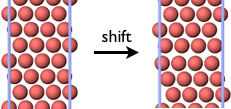

In [2]:
from IPython.core.display import Image
Image(filename='GPFE-1.png')

**Figure 1**: Illustration of the atomic configuration as a perfect crystal and after application of in-plane fault. 

- - -
## LAMMPS input script

The function below returns a LAMMPS input script as a string, where fractional displacement in the [2 -1 -1] fault direction is a variable. Note that this input script includes an equilibrium lattice constant, which is unique to each interatomic potential. This script does the following:

1. Creates a perfect crystal
1. Performs a minimization for relaxation of the free surfaces, which is the boundary condition in the direction normal to the fault plane
1. Writes potential energy to a file
1. Applies a relative fractional displacement of the two crystal halves
1. Performs a minimization for relaxation of atoms affected by the creation of a fault
1. Writes potential energy to a file

This input script implementation requires a meam parameter file, which is described in the next section.

In [3]:
def lammps_script(displacement):
   return'\n'.join(['# ---------- Initialization ----------',
                    'units metal',
                    'boundary p p m',
                    'atom_style atomic',
                    '# ---------- Atomic configuration ----------',
                    '# NOTICE:',
                    '# Equilibrium lattice constant (4.05 here) is unique to the chosen interatomic potential.',
                    'lattice fcc 4.05 orient x 0 -1 1 orient y 2 -1 -1 orient z 1 1 1 origin 0.01 0.01 0.01 spacing 1.414214 2.449490 1.732051',
                    'region box block 0 1 0 1 0 6',
                    'region r1  block 0 1 0 1 0 3',
                    'region r2  block 0 1 0 1 3 6',
                    'create_box 1 box',
                    'create_atoms 1 box',
                    'group g2 region r2',
                    '# ---------- Interatomic potential ----------',
                    'pair_style meam',
                    'pair_coeff * * ../../Jelinek_2012_meamf AlS ../../Jelinek_2012_meam.alsimgcufe AlS',
                    '# ---------- Variables to write to LAMMPS output file ----------',
                    'variable PE equal pe',
                    'variable LX equal lx',
                    'variable LY equal ly',
                    'variable LZ equal lz',
                    'variable PXX equal pxx',
                    'variable PYY equal pyy',
                    'variable PZZ equal pzz',
                    'variable PYZ equal pyz',
                    'variable PXZ equal pxz',
                    'variable PXY equal pxy',
                    'variable nAtoms equal count(all)',
                    'thermo 1000',
                    'thermo_style custom step temp pe ke etotal lx ly lz pxx pyy pzz pyz pxz pxy',
                    '# ---------- Minimization details ----------',
                    'min_style sd',
                    'fix relaxz all setforce 0.0 0.0 NULL',
                    '# ---------- Minimize single crystal (causes surface relaxation) ----------',
                    'minimize 0.0 1.0e-12 10000 100000',
                    '# ---------- Write thermodynamic information to file ----------',
                    'fix print all print 1 "${nAtoms} ${PE} ${LX} ${LY} ${LZ} ${PXX} ${PYY} ${PZZ} ${PYZ} ${PXZ} ${PXY}" file data.0.txt',
                    'run 1',
                    'unfix print',
                    '# ---------- Apply relative displacement ----------',
                    'displace_atoms g2 move 0.0 %lf 0.0' % displacement,
                    '# ---------- Minimize faulted crystal (causes interface relaxation) ----------',
                    'minimize 0.0 1.0e-12 10000 100000',
                    '# ---------- Write thermodynamic information to file ----------',
                    'fix print all print 1 "${nAtoms} ${PE} ${LX} ${LY} ${LZ} ${PXX} ${PYY} ${PZZ} ${PYZ} ${PXZ} ${PXY}" file data.1.txt',
                    'run 1',
                    'unfix print'])

- - -
## Write MEAM Parameters

To make this notebook self-contained, we have embedded the following interatomic potential from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

### Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

**Notes:** This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

**Notice:** Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation.  

In [4]:
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

In [5]:
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

- - -
## Determine Notebook Path

This path is used in subsequent sections.

In [11]:
import os
notebook_directory=os.getcwd()
notebook_directory

'/opt/demo/md/Stacking-Fault-Energy-Demo/simulations/053c8a99-5f07-4135-8cc5-2f925244a42e'

- - -
## Calculate Fault Energy

Below, we define a function that:

1. Creates a unique simulation directory
1. Writes a unique LAMMPS input script
1. Runs LAMMPS as a subprocess
1. Reads output files
1. Computes the fault energy in mJ/m^2
1. Returns the displacement and fault energy

In [7]:
import os
import uuid
import subprocess
import numpy

def simulate_fault_energy(displacement):
    
    # Make a random simulation directory
    simulation_directory=os.path.join(notebook_directory,'simulations',str(uuid.uuid4()))
    os.makedirs(simulation_directory)
    os.chdir(simulation_directory)
    
    # Write a LAMMPS script
    f = open('in.gpfe', 'w')
    f.write(lammps_script(displacement))
    f.close()
    
    # Run LAMMPS
#     subprocess.call(['lmp_serial < in.gpfe'], shell=True)
    subprocess.call(['lmp_ubuntu < in.gpfe'], shell=True)
    # Read results
    data0 = numpy.loadtxt('data.0.txt') # After surface relaxation
    data1 = numpy.loadtxt('data.1.txt') # After surface relaxation and fault
    simBoxSize=[data0[2],data0[3],data0[4]]
    e0=data0[1]
    e1=data1[1]
    
    # Compute fault energy in mJ/m^2
    fault_energy=(e1-e0)/(simBoxSize[0]*simBoxSize[1])*16021.7657
    
    # Return to Notebook directory
    os.chdir(notebook_directory)
    
    # Return displacement and fault energy
    return displacement,fault_energy

Execute fault energy function within a numpy array for a set of 21 equally-spaced displacements between 0.0 and 0.5 (inclusive):

In [9]:
fault_energy_results=numpy.array([simulate_fault_energy(d) for d in numpy.linspace(0,0.5,10)])

IOError: [Errno 2] No such file or directory: 'data.0.txt'

- - -
## Plot Results

Plot the fault energy simulation results using matplotlib:

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.family' : 'serif','font.size': 22})

#fig = plt.figure(figsize(12,8))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('$[2\,\overline{1}\,\overline{1}]$ shift $\Delta$ (fraction)')
ax.set_ylabel('\nFault energy ($mJ/m^2$)')
ax.plot(fault_energy_results[:,0],fault_energy_results[:,1],'o-')
plt.show()

**Figure 2**: Fault energy vs fractional displacement in the [2 -1 -1] direction.

- - -
## Discussion

Figure 2 shows a fault energy path starting and ending at shift fractions corresponding to perfect crystal. A local minimum is observed at 0.325 and a local maximum is observed at 0.40, which are known as the stable and unstable stacking fault energy respectively. 

- - -
## References

\[1\] C.A. Becker, F. Tavazza and L.E. Levine, Implications of the choice of interatomic potential on calculated planar faults and surface properties in nickel, Phil. Mag. 91, 3578-3597 (2011).

\[2\] \(a\) http://lammps.sandia.gov/index.html. \(b\) S. Plimpton, Fast Parallel Algorithms for Short-Range Molecular Dynamics, J. Comp. Phys. 117, 1-19 (1995)

- - -
## Software Disclaimer

NIST-developed software is provided by NIST as a public service. You may use, copy and distribute copies of the software in any medium, provided that you keep intact this entire notice. You may improve, modify and create derivative works of the software or any portion of the software, and you may copy and distribute such modifications or works. Modified works should carry a notice stating that you changed the software and should note the date and nature of any such change. Please explicitly acknowledge the National Institute of Standards and Technology as the source of the software.

NIST-developed software is expressly provided "AS IS." NIST MAKES NO WARRANTY OF ANY KIND, EXPRESS, IMPLIED, IN FACT OR ARISING BY OPERATION OF LAW, INCLUDING, WITHOUT LIMITATION, THE IMPLIED WARRANTY OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, NON-INFRINGEMENT AND DATA ACCURACY. NIST NEITHER REPRESENTS NOR WARRANTS THAT THE OPERATION OF THE SOFTWARE WILL BE UNINTERRUPTED OR ERROR-FREE, OR THAT ANY DEFECTS WILL BE CORRECTED. NIST DOES NOT WARRANT OR MAKE ANY REPRESENTATIONS REGARDING THE USE OF THE SOFTWARE OR THE RESULTS THEREOF, INCLUDING BUT NOT LIMITED TO THE CORRECTNESS, ACCURACY, RELIABILITY, OR USEFULNESS OF THE SOFTWARE.

You are solely responsible for determining the appropriateness of using and distributing the software and you assume all risks associated with its use, including but not limited to the risks and costs of program errors, compliance with applicable laws, damage to or loss of data, programs or equipment, and the unavailability or interruption of operation. This software is not intended to be used in any situation where a failure could cause risk of injury or damage to property. The software developed by NIST employees is not subject to copyright protection within the United States.